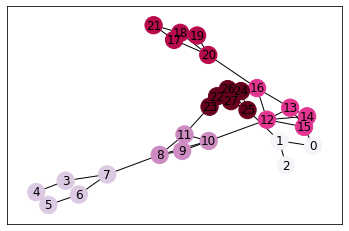

In [1]:
from pooling import *
import networkx as nx
from cluster import *
import sys
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import math
from shapes import *
from build_structure import *
# first layer
list_shapes = [['Chain', 3],['Cycle', 5],['Clique', 4], ['House'], ['House'], ['Diamond']]
Gg, G, colors, index_roles, label_shape = build_lego_structure_from_structure(list_shapes, plot=True, color = 'subgraph', savefig=False,graph_type='nx.connected_watts_strogatz_graph', graph_args=[2,0.4],save2text='',add_node=0)

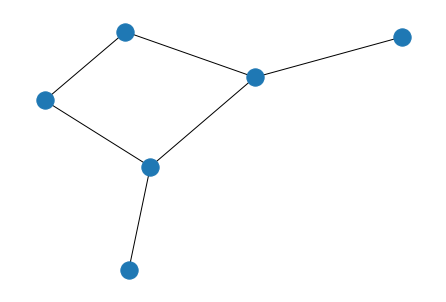

In [2]:
nx.draw(Gg)
G0 = U.from_networkx(G)
edge_index = G0.edge_index
avg = torch.tensor(colors,dtype=torch.float32) 
f = torch.normal(mean=avg,std=0.2)
G0.x = f[:,None] # feature_size = 1
x = G0.x

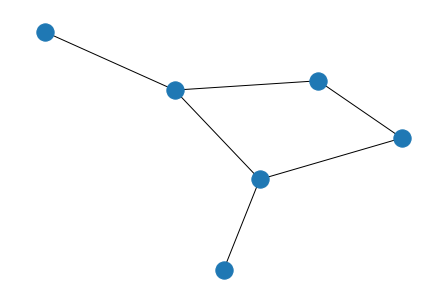

In [7]:
pooling_layer = dissimpooling(score_method='distance', in_channels=1, p=2, normalize=False, self_add=0.5, upper_bound=1.5, greedy=False, select=True)
edge_index_new, x_new, selected_assignment_matrix, selected_node_score_matrix, unpool_info = pooling_layer(x, edge_index)
data = Data(x=x_new, edge_index=edge_index_new)
G_new = U.to_networkx(data, to_undirected=True)
nx.draw(G_new)

In [8]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear

class dispooling_GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.pooling_layer = dissimpooling(score_method='distance', in_channels=hidden_channels, p=2, normalize=False, self_add=0.5, upper_bound=1.5, greedy=False, select=True)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        edge_index, h, _, _, _ = pooling_layer(h, edge_index)
        h = self.conv2(h, edge_index)
        h = h.relu()
        # Apply a final (linear) classifier.
        h = h.mean(dim=0,keepdim=True)
        h = self.lin(h).relu()
        return F.log_softmax(h, dim=-1)
        

In [9]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='data/MUTAG', name='MUTAG')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = dispooling_GCN(dataset.num_node_features, 32, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train():
    model.train()
    for data in dataset:
        optimizer.zero_grad() 
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        return(loss)

# def val():
#     model.eval()
#     pred = model(data.x, data.edge_index).argmax(dim=1)
#     correct = int((pred[data.val_mask] == data.y[data.val_mask]).sum())
#     return correct / int(data.val_mask.sum())

# def test():
#     model.eval()
#     pred = model(data.x, data.edge_index).argmax(dim=1)
#     correct = int((pred[data.test_mask] == data.y[data.test_mask]).sum())
#     return correct / int(data.test_mask.sum())

train()

best_val_acc = 0
for epoch in range(201):
    train_loss = train()
    # val_acc = val()
    # if val_acc > best_val_acc:
    #     test_acc = test()
    #     best_val_acc = val_acc 
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}')
        # print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, '
        #     f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


TypeError: only integer tensors of a single element can be converted to an index

In [77]:

conv1 = GCNConv(in_channels, hidden_channels)
pooling_layer = dissimpooling(score_method='distance', in_channels=hidden_channels, p=2, normalize=False, self_add=0.5, upper_bound=1.5, greedy=False, select=True)
conv2 = GCNConv(hidden_channels, hidden_channels)
lin = torch.nn.Linear(hidden_channels, out_channels)


h = conv1(x, edge_index)
h = h.relu()
edge_index, h, _, _, _ = pooling_layer(h, edge_index)
h = conv2(h, edge_index)
h = h.relu()
# Apply a final (linear) classifier.
h = h.mean(dim=0,keepdim=True)
h = lin(h).relu()



TypeError: only integer tensors of a single element can be converted to an index